In [1]:
import numpy as np
import pandas as pd

In [2]:
df = pd.read_csv("Stammdaten.csv", low_memory=False)

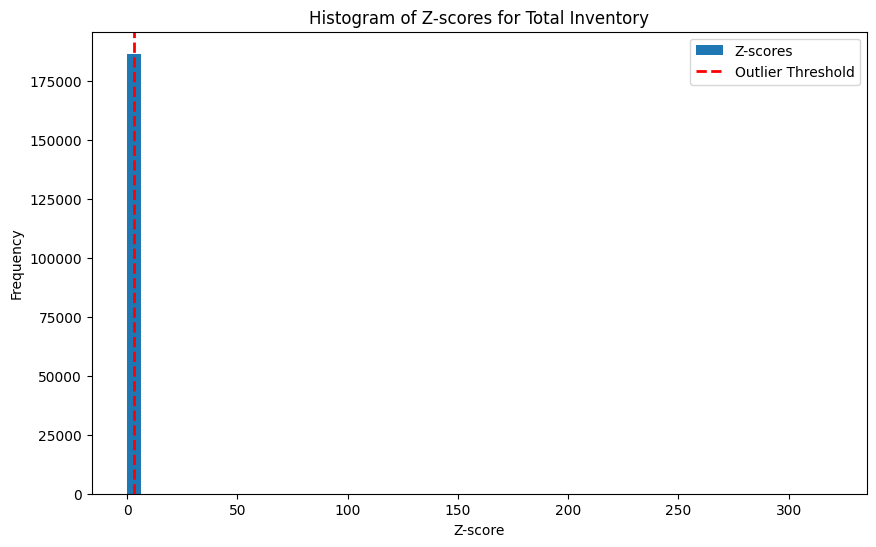

In [3]:
import pandas as pd
import numpy as np
import xgboost as xgb
from scipy import stats
import matplotlib.pyplot as plt

# Encode categorical variables
categorical_columns = df.select_dtypes(include=['object']).columns
df[categorical_columns] = df[categorical_columns].apply(lambda col: pd.factorize(col)[0])

# Identify numeric columns for statistical analysis
numeric_columns = ['Materialnummer', 'Lieferant OB', 'Vertrag OB', 'Vertragsposition OB', 'Planlieferzeit Vertrag', 
                   'Vertrag Fix1', 'Sonderbeschaffungsart', 'Disponent', 'Einkäufer', 'Gesamtbestand', 
                   'Werk OB', 'Werk Infosatz', 'Infosatznummer', 'Infosatztyp', 'WE-Bearbeitungszeit',
                   'Planlieferzeit Mat-Stamm', 'Warengruppe']

# Handling missing values by replacing them with the median of each column
for col in numeric_columns:
    if df[col].isna().any():
        df[col].fillna(df[col].median(), inplace=True)

# Applying Z-score for anomaly detection in numeric columns
for col in numeric_columns:
    df[col + '_z_score'] = np.abs(stats.zscore(df[col]))
    df[col + '_outlier'] = 0
    df.loc[df[col + '_z_score'] > 3, col + '_outlier'] = 1  # Any Z-score > 3 is considered an outlier

# Combine all outlier flags to a single anomaly label
df['anomaly_label'] = df[[col + '_outlier' for col in numeric_columns]].max(axis=1)

# Train XGBoost model for anomaly detection
xgb_model = xgb.XGBClassifier(objective='binary:logistic', random_state=42)
xgb_model.fit(df[numeric_columns], df['anomaly_label'])

# Predict anomaly labels using XGBoost
df['xgb_anomaly'] = xgb_model.predict(df[numeric_columns])

# Visualize statistical outliers in one of the numeric columns
plt.figure(figsize=(10, 6))
plt.hist(df['Gesamtbestand_z_score'], bins=50, label='Z-scores')
plt.axvline(3, color='red', linestyle='dashed', linewidth=2, label='Outlier Threshold')
plt.title('Histogram of Z-scores for Total Inventory')
plt.xlabel('Z-score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Save the updated dataset
df.to_csv('xgboost_with_anomalies.csv', index=False)


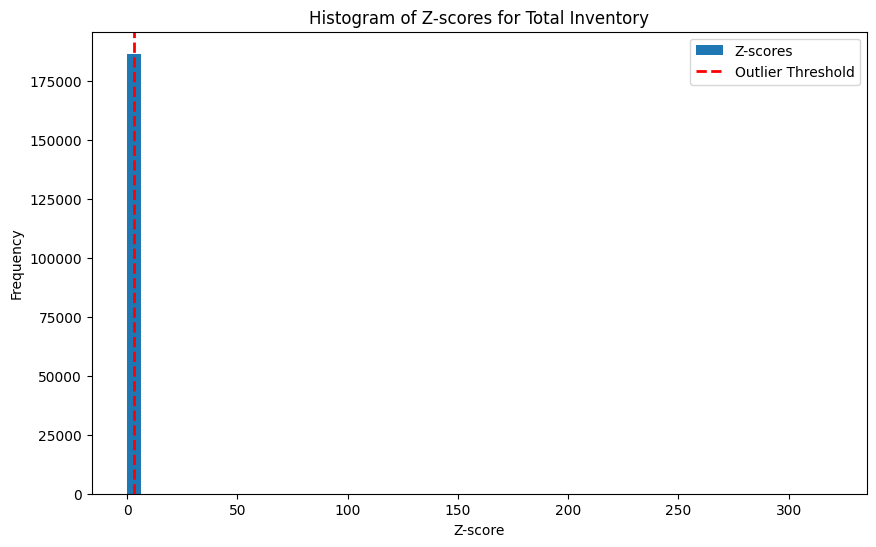

In [4]:
import pandas as pd
import numpy as np
from sklearn.ensemble import IsolationForest
from scipy import stats
import matplotlib.pyplot as plt


# Encode categorical variables
categorical_columns = df.select_dtypes(include=['object']).columns
df[categorical_columns] = df[categorical_columns].apply(lambda col: pd.factorize(col)[0])

# Identify numeric columns for statistical analysis
numeric_columns = ['Materialnummer', 'Lieferant OB', 'Vertrag OB', 'Vertragsposition OB', 'Planlieferzeit Vertrag', 
                   'Vertrag Fix1', 'Sonderbeschaffungsart', 'Disponent', 'Einkäufer', 'Gesamtbestand', 
                   'Werk OB', 'Werk Infosatz', 'Infosatznummer', 'Infosatztyp', 'WE-Bearbeitungszeit',
                   'Planlieferzeit Mat-Stamm', 'Warengruppe']

# Handling missing values by replacing them with the median of each column
for col in numeric_columns:
    if df[col].isna().any():
        df[col].fillna(df[col].median(), inplace=True)

# Applying Z-score for anomaly detection in numeric columns
for col in numeric_columns:
    df[col + '_z_score'] = np.abs(stats.zscore(df[col]))
    df[col + '_outlier'] = 0
    df.loc[df[col + '_z_score'] > 3, col + '_outlier'] = 1  # Any Z-score > 3 is considered an outlier

# Combine all outlier flags to a single anomaly label
df['anomaly_label'] = df[[col + '_outlier' for col in numeric_columns]].max(axis=1)

# Apply Isolation Forest for an overall anomaly detection perspective
iso = IsolationForest(random_state=42)
iso.fit(df[numeric_columns])
df['iso_scores'] = iso.decision_function(df[numeric_columns])
df['iso_outlier'] = iso.predict(df[numeric_columns])

# Visualize statistical outliers in one of the numeric columns
plt.figure(figsize=(10, 6))
plt.hist(df['Gesamtbestand_z_score'], bins=50, label='Z-scores')
plt.axvline(3, color='red', linestyle='dashed', linewidth=2, label='Outlier Threshold')
plt.title('Histogram of Z-scores for Total Inventory')
plt.xlabel('Z-score')
plt.ylabel('Frequency')
plt.legend()
plt.show()

# Save the updated dataset
df.to_csv('iforest_with_anomalies.csv', index=False)


Evaluation Metrics for Isolation Forest:
[[     0   5151  12712]
 [     0      0      0]
 [     0 163211   5682]]


/home/gravityfall0-007/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gravityfall0-007/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gravityfall0-007/anaconda3/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/gra

              precision    recall  f1-score   support

          -1       0.00      0.00      0.00     17863
           0       0.00      0.00      0.00         0
           1       0.31      0.03      0.06    168893

    accuracy                           0.03    186756
   macro avg       0.10      0.01      0.02    186756
weighted avg       0.28      0.03      0.05    186756

Evaluation Metrics for XGBoost:
[[168361      0]
 [     1  18394]]
              precision    recall  f1-score   support

           0       1.00      1.00      1.00    168361
           1       1.00      1.00      1.00     18395

    accuracy                           1.00    186756
   macro avg       1.00      1.00      1.00    186756
weighted avg       1.00      1.00      1.00    186756



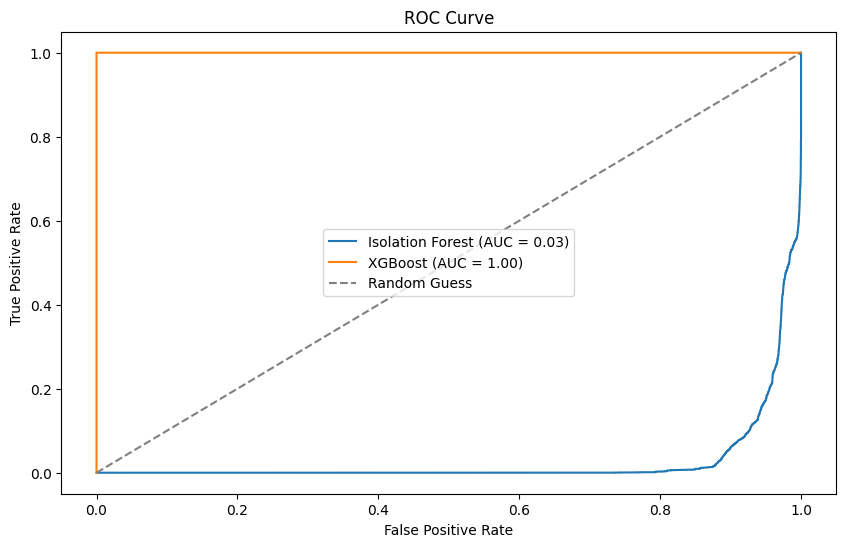

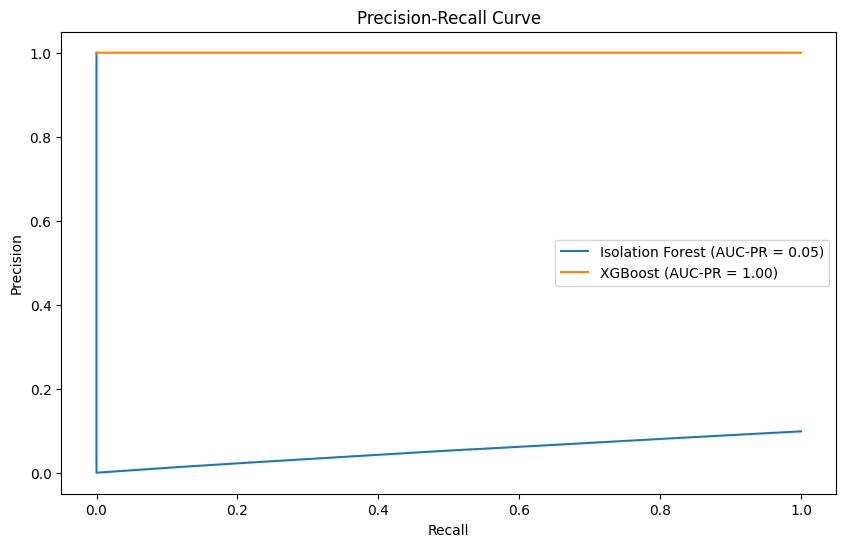

In [5]:
from sklearn.metrics import confusion_matrix, classification_report, roc_curve, roc_auc_score, precision_recall_curve, auc

# Evaluate Isolation Forest
print("Evaluation Metrics for Isolation Forest:")
print(confusion_matrix(df['iso_outlier'], df['anomaly_label']))
print(classification_report(df['iso_outlier'], df['anomaly_label']))

# Calculate ROC curve and AUC for Isolation Forest
iso_fpr, iso_tpr, _ = roc_curve(df['anomaly_label'], df['iso_scores'])
iso_auc = roc_auc_score(df['anomaly_label'], df['iso_scores'])

# Calculate precision-recall curve and AUC-PR for Isolation Forest
iso_precision, iso_recall, _ = precision_recall_curve(df['anomaly_label'], df['iso_scores'])
iso_auc_pr = auc(iso_recall, iso_precision)

# Evaluate XGBoost
print("Evaluation Metrics for XGBoost:")
print(confusion_matrix(df['xgb_anomaly'], df['anomaly_label']))
print(classification_report(df['xgb_anomaly'], df['anomaly_label']))

# Predict anomaly scores using XGBoost
xgb_scores = xgb_model.predict_proba(df[numeric_columns])[:, 1]

# Calculate ROC curve and AUC for XGBoost
xgb_fpr, xgb_tpr, _ = roc_curve(df['anomaly_label'], xgb_scores)
xgb_auc = roc_auc_score(df['anomaly_label'], xgb_scores)

# Calculate precision-recall curve and AUC-PR for XGBoost
xgb_precision, xgb_recall, _ = precision_recall_curve(df['anomaly_label'], xgb_scores)
xgb_auc_pr = auc(xgb_recall, xgb_precision)

# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(iso_fpr, iso_tpr, label=f'Isolation Forest (AUC = {iso_auc:.2f})')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()
plt.show()

# Plot precision-recall curves
plt.figure(figsize=(10, 6))
plt.plot(iso_recall, iso_precision, label=f'Isolation Forest (AUC-PR = {iso_auc_pr:.2f})')
plt.plot(xgb_recall, xgb_precision, label=f'XGBoost (AUC-PR = {xgb_auc_pr:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()
plt.show()


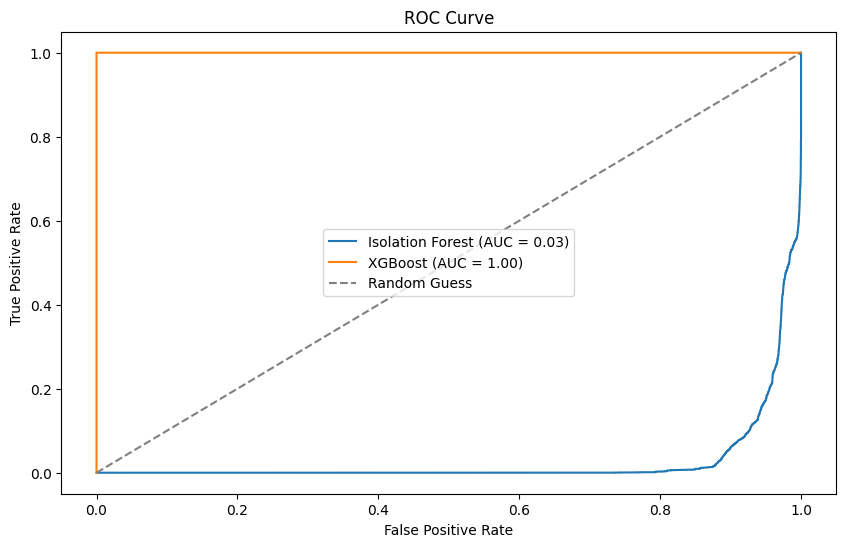

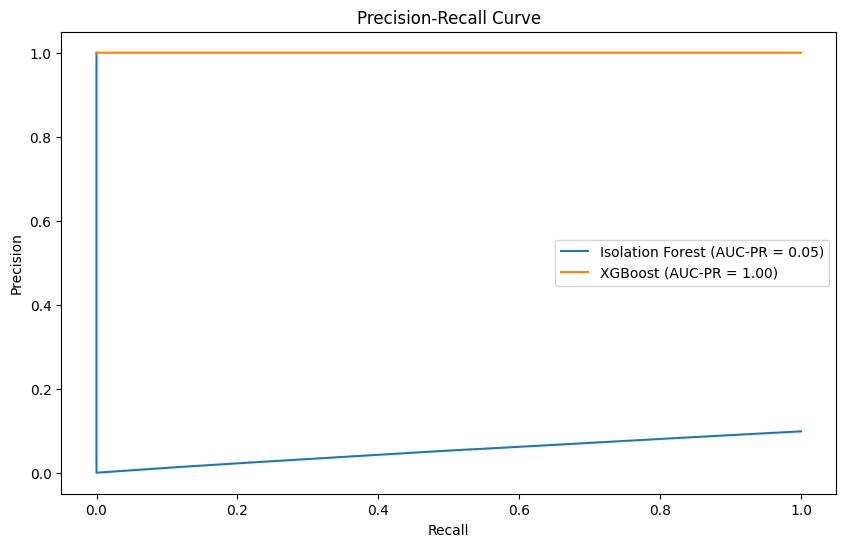

In [6]:
# Plot ROC curves
plt.figure(figsize=(10, 6))
plt.plot(iso_fpr, iso_tpr, label=f'Isolation Forest (AUC = {iso_auc:.2f})')
plt.plot(xgb_fpr, xgb_tpr, label=f'XGBoost (AUC = {xgb_auc:.2f})')
plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Random Guess')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend()

# Save ROC curve plot as an image
plt.savefig('roc_curve.png')

# Show the plot
plt.show()

# Plot precision-recall curves
plt.figure(figsize=(10, 6))
plt.plot(iso_recall, iso_precision, label=f'Isolation Forest (AUC-PR = {iso_auc_pr:.2f})')
plt.plot(xgb_recall, xgb_precision, label=f'XGBoost (AUC-PR = {xgb_auc_pr:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.legend()

# Save precision-recall curve plot as an image
plt.savefig('precision_recall_curve.png')

# Show the plot
plt.show()
